# Part 4 : 模型评测

<br>

### 任务目标

1. 加载Qwen2.5-7B模型及对应LoRA权重，进行推理任务；
2. 准备评测数据集，基于该分类场景定义评测指标，并进行优化改良；
3. 对评测数据集进行推理，计算得分并利用Pandas绘图展示；
4. 分析不同Learning Rate、LoRA Rank、数据集大小下，对该任务的影响。
   
<br>
<br>

In [1]:
import os
import json
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from peft import PeftModel
from IPython.display import display, clear_output
from peft import LoraConfig, TaskType, get_peft_model
import matplotlib.pyplot as plt

In [11]:
model_path = 'llm-model/Qwen/Qwen2___5-7B-Instruct'
lora_path = "lora_output/Qwen2.5_instruct_lora_8r_lr=1e-4_1446data_epochs=1/checkpoint-90"
eval_dataset_path = "dataset/sa_article_evaldata_76.json"

---

<br>

## 一、微调模型准备

### 1.1 定义 LoraConfig

LoRA 通过将权重矩阵分解为低秩矩阵的形式（两个小矩阵的乘积），`LoraConfig`这个类的参数可以控制这些低秩矩阵的特性，如秩（rank）。通过配置，决定对模型的哪些层（如 Transformer 的注意力层）应用 LoRA，而不是调整整个模型的参数。通过配置 LoRA 参数化策略，以实现高效、灵活的模型微调。

- `task_type`：模型类型，在这里为`TaskType.CAUSAL_LM`，代表因果语言建模任务（如 GPT 的文本生成任务）；
- `target_modules`：指定模型中哪些模块将被应用 LoRA 更新，主要就是 `attention`部分的层，不同的模型对应的层的名字不同，可以传入数组，也可以字符串，也可以正则表达式；
- `target_modules`：控制 LoRA 是否处于推理模式。推理模式。此时，LoRA 不会再训练，直接使用已训练好的低秩矩阵；
- `r`：lora的秩；
- `lora_alpha`：LoRA 的缩放因子，用于调整低秩更新矩阵的影响力。

In [3]:
config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    inference_mode=True, # 推理模式
    r=8, # Lora 秩
    lora_alpha=32, 
    lora_dropout=0.1# Dropout 比例
)

<br>

### 1.2 加载Lora权重和模型

In [4]:
# 加载tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 加载模型
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto",torch_dtype=torch.bfloat16)

# 加载lora权重
model = PeftModel.from_pretrained(model, model_id=lora_path, config=config)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<br>

### 1.3 定义推理函数

In [5]:
# LORA模型推理
def lora_model_qwen(prompt):
    messages = [
    {"role": "system", "content": "将以下文本按照【其他、云计算、架构师、计算机、个人娱乐、人工智能、商业案例、汽车行业、经济观察】标签纬度进行关联度评分"},
    {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to('cuda')
    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512
    )
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

In [6]:
# Demo样例数据测试Lora微调后效果
article_unproceed = "深圳福田杀出超级独角兽：估值6300亿，全球第一 关键词: 拉拉 物流 服务 平台 亿美元 2023 全球 中国 司机 公司 货运 市场 配送 商户 提供 2024 GTV 收入 中国香港 连接 核心句子: 2023年，货拉拉促成了超过5.884亿笔订单，全球货运GTV达到87.363亿美元；2024年上半年，平台促成了超过3.379亿笔订单，全球货运GTV为46.033亿美元，月活跃商户约为1520万个，月活跃司机约为140万名 历经11年发展，根据弗若斯特沙利文研究报告，货拉拉在2024年上半年实现了多个“第一”：全球闭环货运GTV（交易总额）最大、全球同城物流交易平台闭环货运GTV最大、全球平均月活跃商户最多、以及全球已完成订单数量最多的物流交易平台 3、特定行业物流平台：例如冷链物流、危险品物流、卡车物流（货车帮）、大型物流公司（安能物流）等 财务数据显示，2021年至2023年间，货拉拉的营业收入逐年增长，分别达到了8.45亿美元、10.36亿美元和13.34亿美元，而净利润则从2021年的亏损20.86亿美元逐渐转正，至2023年实现了9.73亿美元的盈利 与这三类公司相比，货拉拉有几个核心区别：1、与京东、顺丰等大型物流..."
lora_model_qwen(article_unproceed)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'{"其他": 1, "云计算": 2, "架构师": 3, "计算机": 5, "个人娱乐": 1, "人工智能": 4, "商业案例": 8, "汽车行业": 2, "经济观察": 7}'

---

<br>

## 二、评测数据集准备

In [12]:
# 加载评测数据集
with open(eval_dataset_path, "r", encoding="utf-8") as file:
    eval_dataset = json.load(file)
display(pd.DataFrame(eval_dataset)[:5].style.set_properties(**{'text-align': 'left'}))

,instruction,input,output
0,将以下文本分类,凯悦酒店又给自己的软品牌找了个“大金主” 关键词: 酒店 品牌 凯悦 合作 集团 华润 业主 国际 独立 市场 旗下 对于 精选 管理 尚选 大家 带来 物业 体验 它们 核心句子: 图片来源 | 酒店资源洲际旗下的洲至奢选、voco、金普顿酒店及餐厅，希尔顿旗下的希尔顿格芮精选酒店、希尔顿启缤精选酒店、LXR酒店及度假村，雅高旗下的美憬阁酒店、Tribe酒店等，都是各大酒店集团的软品牌 今年初，凯悦与黄龙酒店管理集团合作，后者获得凯悦独立品牌酒店与精选服务品牌酒店的特许经营授权 大家如果留神此次双方合作，就会关注到除了这个合资品牌之外，凯悦与华润还宣布达成战略合作协议以带来更多凯悦品牌酒店，并签约包括西安柏悦酒店和东莞安达仕酒店在内的重点项目 前两天，凯悦酒店集团和华润置地宣布达成战略合作，成立合资公司开发和管理华润置地旗下木棉花品牌酒店品牌 截至目前，双方合作的项目包括深圳君悦酒店、大连君悦酒店、沈阳君悦酒店、杭州柏悦酒店、合肥君悦酒店、厦门安达仕酒店以及深圳湾安达仕酒店等 根据此次双方在新闻发布会上透露的内容，新公司将开发和管理位于北京、深圳、成都、杭州和日照的6家现有木棉花品牌酒店，以及位于绍兴和上海的两家全新木棉花酒...,"{""其他"": 2, ""云计算"": 1, ""架构师"": 1, ""计算机"": 2, ""个人娱乐"": 0, ""人工智能"": 1, ""商业案例"": 8, ""汽车行业"": 0, ""经济观察"": 5}"
1,将以下文本分类,MOBA大战前夕：百万《王者荣耀》玩家参与沐瞳《决胜巅峰》测试？后者买量开怼“小王” 关键词: 决胜 巅峰 素材 内容 王者 测试 游戏 荣耀 DataEye 数据 平台 官方 视频 主要 皮肤 玩家 研究院 粉丝 10 英雄 核心句子: 我们大致盘点了《决胜巅峰》带号投广的抖音达人，主要分两类：一类是泛游戏达人，什么内容都发，不限于《决胜巅峰》，比如红蓝机（游戏解说）粉丝18.4万、啸意网络粉丝4.6万；另一类是名字就带“决胜巅峰”的达人，主发该游戏，比如秋白（决胜巅峰）粉丝5.8万，他们此前还发MLBB 二、内容传播测情况【事实＆数据】社媒传播方面，我们邀请到了数说故事提供相关数据（数说故事官方简介：中国领先的一站式大数据及AI智能应用提供商，构建了从数据收集、处理、分析、建模到商业应用的全价值链解决方案，旗下拥有数说雷达、数说睿见、数说聚合等50+应用）以下来自数说故事旗下互联网大数据获取与分析平台——数说聚合 招式、概念再针对，面对《王者荣耀》的体量以及社交优势、网络效应（链接网络的节点越多、越有价值，即玩的人越多、越好玩） 沐瞳背靠字节，不缺钱、不缺量，但核心问题是没法做“全球同服”——海外月活跃1.1亿，在国内也就表面宣传，不能形成网络节点形成世界一服 Da...,"{""其他"": 3, ""云计算"": 2, ""架构师"": 0, ""计算机"": 8, ""个人娱乐"": 9, ""人工智能"": 1, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 5}"
2,将以下文本分类,顺丰控股10月21日放量下跌0.52%；顺丰控股9月营收增长9.01% 供应链及国际业务显著提升,"{""其他"": 0, ""云计算"": 0, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 8}"
3,将以下文本分类,隆基绿能10月21日放量上涨6.44%；隆基绿能参与光伏行业“防内卷”座谈会,"{""其他"": 3, ""云计算"": 0, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 5}"
4,将以下文本分类,贵州茅台10月21日缩量下跌0.79%；贵州茅台董事长张德芹分享ESG实践,"{""其他"": 2, ""云计算"": 0, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 8}"


---

<br>

## 三、模型评估

### 3.1 模型评测方法
分类任务（Classification）是机器学习中一种基础任务类型。简单来说，分类任务要求模型根据给定的输入文本，将其划分到预定义的类别中。例如，一封电子邮件可能被分类为“垃圾邮件”或“正常邮件”，一条新闻可能被归类为“体育”、“科技”或“娱乐”等。在分类任务中，模型需要学习从输入文本中提取关键语义信息，并根据这些信息进行判断，最终给出分类结果。

模型的预测样本可以根据真实类别与预测类别是否一致来对样本进行组合划分。以基础的二分类任务为例，真正例（True Positive, TP）表示预测类别为正的正样本、假正例（FalsePositive, FP）表示预测类别为正的负样本、真负例（True Negative, TN）表示预测类别为负的负样本、假负例（False Negative, FN）表示预测类别为负的正样本。

在此基础上，分类任务通常采用精确率（Precision）、召回率（Recall）、F1 分数（F1 Score）等评测指标来评估模型的分类结果。本Demo任务从大类来看是属于分类任务，模型需要判断文章属于归属于哪个标签。但和传统的分类任务不同，还要根据相关性进行打分，这种场景下允许对打分有一定误差。因此需要对精确率、召回率指标进行微调。

我们定义基于差值的容忍范围（本次评测容忍误差=2）。例如，【商业案例】 的真实值为 9，预测值为 8，差值为 1，在容忍范围内被视为正确预测。此外，**为更精准的定义模型效果，我们新增两个指标加权准确率、加权误差。**

<br>


- **精确率**：表示模型预测为正例的样本中真正为正例的比例（容忍误差范围内），其定义为：
$$
\text{Precision} = \frac{\text{TP}}{\text{TP+FP}}
$$
- **召回率**：表示所有真正为正例的样本中被模型正确预测出来的比例（容忍误差范围内），其定义为：
$$
\text{Recall} = \frac{\text{TP}}{\text{TP+FN}}
$$
- **F1分数**：是精确率和召回率的调和平均数（容忍误差范围内），用于衡量模型在分类任务上的综合性能，其定义为：
$$
\text{F1} = 2 \times \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- **加权准确率（Weighted Accuracy）**：是对模型整体预测准确度的衡量，它考虑了预测值与真实值之间的差异，并将差异进行归一化。可以理解为误差反向的加权准确率。如果预测值与真实值完全一致（差值为 0），Weighted Accuracy 为 1。如果所有预测值的差值都达到最大值（例如 10），Weighted Accuracy 为 0。其定义为：
$$
\text{Weighted Accuracy} = 1 - \frac{\sum_{i=1}^N |\text{pred}_i - \text{truth}_i|}{N \cdot \text{max\_score}}
$$
<div align="center">

$$
|\text{pred}_i - \text{truth}_i|：预测值与真实值的绝对差值。  
N：总样本数。  
\text{max\_score}：评分体系中的满分值（10 分）。
$$
</div>

- **加权误差（Weighted Error）**：是对预测误差的直接量化，表示每个字段预测值与真实值之间的平均差距。它是未经归一化的误差绝对值平均值，能够反映模型输出的偏差程度。其定义为：
$$
\text{Weighted Error} = \frac{\sum_{i=1}^N |\text{pred}_i - \text{truth}_i|}{N}
$$
<div align="center">

$$
\sum_{i=1}^N |\text{pred}_i - \text{truth}_i|：所有预测值与真实值的绝对差值之和。 \\  
N：总样本数。
$$

</div>


<br>

### 3.2 定义模型评测函数

In [8]:
def model_eval(ground_truth_output, model_output):
    # 加载预测结果
    ground_truth = json.loads(ground_truth_output)
    try:
        predicted = json.loads(model_output)
    except json.JSONDecodeError:
        print("模型输出不是有效的 JSON 格式")
        predicted = {}
    
    # 最大分数范围
    # max_score = max(ground_truth.values()) if ground_truth else 1
    max_score = 10
    
    # 计算评测指标
    total_diff = 0
    correct_within_tolerance = 0
    tolerance = 2  # 允许的误差范围
    total_samples = len(ground_truth)
    
    for key, true_value in ground_truth.items():
        pred_value = predicted.get(key, 0)
    
        # 计算绝对差值
        diff = abs(true_value - pred_value)
        total_diff += diff
    
        # 检查是否在容忍范围内
        if diff <= tolerance:
            correct_within_tolerance += 1
    
    # 加权准确率
    weighted_accuracy = 1 - (total_diff / (total_samples * max_score))
    
    # 加权误差
    weighted_error = total_diff / total_samples
    
    # 改进 F1 分数
    precision = correct_within_tolerance / len(predicted) if predicted else 0
    recall = correct_within_tolerance / total_samples
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 输出结果
    results = {
        "weighted_accuracy": weighted_accuracy,
        "weighted_error": weighted_error,
        "precision_with_tolerance": precision,
        "recall_with_tolerance": recall,
        "modified_f1_score": f1_score,
    }
    return results

<br>

### 3.3 开始评测

In [9]:
eval_num = len(eval_dataset)

# 创建一个空的 DataFrame，用于存储实时结果
results_df = pd.DataFrame(columns=["Index", "Input", "Expected Output", "Generated Output", "Evaluation Result"])

for i in range(eval_num):
    input_data = eval_dataset[i]['input']
    expected_output = eval_dataset[i]['output']
    generated_output = lora_model_qwen(input_data)  # 调用模型生成结果
    eval_result = model_eval(expected_output, generated_output)  # 调用评测函数
    
    # 更新 eval_dataset 的字段
    eval_dataset[i]['sft_result'] = generated_output
    eval_dataset[i]['eval_result'] = eval_result

    # 创建一个新的 DataFrame 行
    new_row = pd.DataFrame([{
        "Index": i + 1,
        "Input": input_data,
        "Expected Output": expected_output,
        "Generated Output": generated_output,
        "Evaluation Result": eval_result
    }])
    
    # 使用 pd.concat() 追加新行
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    # 实时清空并展示 DataFrame
    clear_output(wait=True)
    display(results_df.style.set_properties(**{'text-align': 'left'}))

    print(f"第{i+1}条数据已评测完毕，评测结果：{eval_result}")

,Index,Input,Expected Output,Generated Output,Evaluation Result
0,1,凯悦酒店又给自己的软品牌找了个“大金主” 关键词: 酒店 品牌 凯悦 合作 集团 华润 业主 国际 独立 市场 旗下 对于 精选 管理 尚选 大家 带来 物业 体验 它们 核心句子: 图片来源 | 酒店资源洲际旗下的洲至奢选、voco、金普顿酒店及餐厅，希尔顿旗下的希尔顿格芮精选酒店、希尔顿启缤精选酒店、LXR酒店及度假村，雅高旗下的美憬阁酒店、Tribe酒店等，都是各大酒店集团的软品牌 今年初，凯悦与黄龙酒店管理集团合作，后者获得凯悦独立品牌酒店与精选服务品牌酒店的特许经营授权 大家如果留神此次双方合作，就会关注到除了这个合资品牌之外，凯悦与华润还宣布达成战略合作协议以带来更多凯悦品牌酒店，并签约包括西安柏悦酒店和东莞安达仕酒店在内的重点项目 前两天，凯悦酒店集团和华润置地宣布达成战略合作，成立合资公司开发和管理华润置地旗下木棉花品牌酒店品牌 截至目前，双方合作的项目包括深圳君悦酒店、大连君悦酒店、沈阳君悦酒店、杭州柏悦酒店、合肥君悦酒店、厦门安达仕酒店以及深圳湾安达仕酒店等 根据此次双方在新闻发布会上透露的内容，新公司将开发和管理位于北京、深圳、成都、杭州和日照的6家现有木棉花品牌酒店，以及位于绍兴和上海的两家全新木棉花酒...,"{""其他"": 2, ""云计算"": 1, ""架构师"": 1, ""计算机"": 2, ""个人娱乐"": 0, ""人工智能"": 1, ""商业案例"": 8, ""汽车行业"": 0, ""经济观察"": 5}","{""其他"": 3, ""云计算"": 1, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 8}","{'weighted_accuracy': 0.9, 'weighted_error': 1.0, 'precision_with_tolerance': 0.8888888888888888, 'recall_with_tolerance': 0.8888888888888888, 'modified_f1_score': 0.8888888888888888}"
1,2,MOBA大战前夕：百万《王者荣耀》玩家参与沐瞳《决胜巅峰》测试？后者买量开怼“小王” 关键词: 决胜 巅峰 素材 内容 王者 测试 游戏 荣耀 DataEye 数据 平台 官方 视频 主要 皮肤 玩家 研究院 粉丝 10 英雄 核心句子: 我们大致盘点了《决胜巅峰》带号投广的抖音达人，主要分两类：一类是泛游戏达人，什么内容都发，不限于《决胜巅峰》，比如红蓝机（游戏解说）粉丝18.4万、啸意网络粉丝4.6万；另一类是名字就带“决胜巅峰”的达人，主发该游戏，比如秋白（决胜巅峰）粉丝5.8万，他们此前还发MLBB 二、内容传播测情况【事实＆数据】社媒传播方面，我们邀请到了数说故事提供相关数据（数说故事官方简介：中国领先的一站式大数据及AI智能应用提供商，构建了从数据收集、处理、分析、建模到商业应用的全价值链解决方案，旗下拥有数说雷达、数说睿见、数说聚合等50+应用）以下来自数说故事旗下互联网大数据获取与分析平台——数说聚合 招式、概念再针对，面对《王者荣耀》的体量以及社交优势、网络效应（链接网络的节点越多、越有价值，即玩的人越多、越好玩） 沐瞳背靠字节，不缺钱、不缺量，但核心问题是没法做“全球同服”——海外月活跃1.1亿，在国内也就表面宣传，不能形成网络节点形成世界一服 Da...,"{""其他"": 3, ""云计算"": 2, ""架构师"": 0, ""计算机"": 8, ""个人娱乐"": 9, ""人工智能"": 1, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 5}","{""其他"": 3, ""云计算"": 2, ""架构师"": 2, ""计算机"": 7, ""个人娱乐"": 9, ""人工智能"": 4, ""商业案例"": 6, ""汽车行业"": 1, ""经济观察"": 5}","{'weighted_accuracy': 0.9111111111111111, 'weighted_error': 0.8888888888888888, 'precision_with_tolerance': 0.8888888888888888, 'recall_with_tolerance': 0.8888888888888888, 'modified_f1_score': 0.8888888888888888}"
2,3,顺丰控股10月21日放量下跌0.52%；顺丰控股9月营收增长9.01% 供应链及国际业务显著提升,"{""其他"": 0, ""云计算"": 0, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 8}","{""其他"": 3, ""云计算"": 2, ""架构师"": 1, ""计算机"": 2, ""个人娱乐"": 0, ""人工智能"": 1, ""商业案例"": 8, ""汽车行业"": 0, ""经济观察"": 9}","{'weighted_accuracy': 0.8777777777777778, 'weighted_error': 1.2222222222222223, 'precision_with_tolerance': 0.8888888888888888, 'recall_with_tolerance': 0.8888888888888888, 'modified_f1_score': 0.8888888888888888}"
3,4,隆基绿能10月21日放量上涨6.44%；隆基绿能参与光伏行业“防内卷”座谈会,"{""其他"": 3, ""云计算"": 0, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 5}","{""其他"": 5, ""云计算"": 3, ""架构师"": 2, ""计算机"": 2, ""个人娱乐"": 1, ""人工智能"": 4, ""商业案例"": 8, ""汽车行业"": 2, ""经济观察"": 9}","{'weighted_accuracy': 0.7666666666666666, 'weighted_error': 2.3333333333333335, 'precision_with_tolerance': 0.6666666666666666, 'recall_with_tolerance': 0.6666666666666666, 'modified_f1_score': 0.6666666666666666}"
4,5,贵州茅台10月21日缩量下跌0.79%；贵州茅台董事长张德芹分享ESG实践,"{""其他"": 2, ""云计算"": 0, ""架构师"": 0, ""计算机"": 0, ""个人娱乐"": 0, ""人工智能"": 0, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 8}","{""其他"": 3, ""云计算"": 2, ""架构师"": 1, ""计算机"": 1, ""个人娱乐"": 0, ""人工智能"": 2, ""商业案例"": 8, ""汽车行业"": 1, ""经济观察"": 9}","{'weighted_accuracy': 0.8888888888888888, 'weighted_error': 1.1111111111111112, 'precision_with_tolerance': 1.0, 'recall_with_tolerance': 1.0, 'modified_f1_score': 1.0}"
5,6,三六零10月21日缩量上涨1.76%；三六零在成都成立新公司 注册资本5000万元,"{""其他"": 2, ""云计算"": 4, ""架构师"": 3, ""计算机"": 6, ""个人娱乐"": 1, ""人工智能"": 5, ""商业案例"": 7, ""汽车行业"": 2, ""经济观察"": 8}","{""其他"": 3, ""云计算"": 4, ""架构师"": 2, ""计算机"": 8, ""个人娱乐"": 1, ""人工智能"": 5, ""商业案例"": 7, ""汽车行业"": 0, ""经济观察"": 9}","{'weighted_accuracy': 0.9222222222222223, 'weighted_error': 0.7777777777777778, 'precision_with_tolerance': 1.0, 'recall_with_tolerance': 1.0, 'modified_f1_score': 1.0}"
6,7,浪潮信息10月21日缩量上涨0.51%,"{""其他"": 2, ""云计算"": 5, ""架构师"": 3, ""计算机"": 6, ""个人娱乐"": 1, ""人工智能"": 4, ""商业案例"": 7, ""汽车

第77条数据已评测完毕，评测结果：{'weighted_accuracy': 0.8444444444444444, 'weighted_error': 1.5555555555555556, 'precision_with_tolerance': 0.7777777777777778, 'recall_with_tolerance': 0.7777777777777778, 'modified_f1_score': 0.7777777777777778}


<br>

### 3.4 可视化展示结果

平均 weighted_accuracy: 0.86
平均 modified_f1_score: 0.82


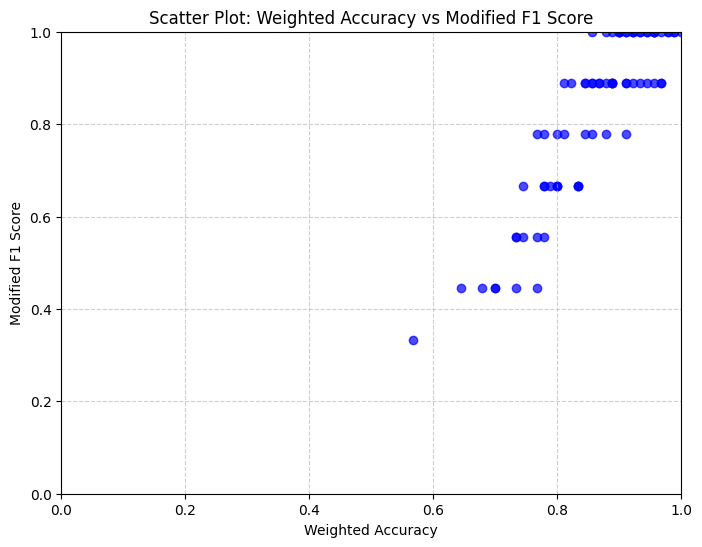

In [10]:
# 安全提取 eval_result，并忽略没有 eval_result 的元素
eval_results = [item['eval_result'] for item in eval_dataset if 'eval_result' in item and isinstance(item['eval_result'], dict)]
df = pd.DataFrame(eval_results)

# 转换为 DataFrame
df = pd.DataFrame(eval_results)

# 计算平均值并用 round 保留小数位
avg_weighted_accuracy = round(df['weighted_accuracy'].mean(), 2)
avg_modified_f1_score = round(df['modified_f1_score'].mean(), 2)

# 打印平均值
print(f"平均 weighted_accuracy: {avg_weighted_accuracy}")
print(f"平均 modified_f1_score: {avg_modified_f1_score}")

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(df['weighted_accuracy'], df['modified_f1_score'], color='blue', alpha=0.7)

# 设置横纵轴范围为 [0, 1]
plt.xlim(0, 1)
plt.ylim(0, 1)

# 添加标题和轴标签
plt.title('Scatter Plot: Weighted Accuracy vs Modified F1 Score')
plt.xlabel('Weighted Accuracy')
plt.ylabel('Modified F1 Score')

# 显示网格
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图表
plt.show()

<br>

### 3.5 输出评测结果

In [11]:
# 转换为 DataFrame
df = pd.DataFrame(eval_dataset)

# 检查 eval_result 是否存在并展开为多个列
if 'eval_result' in df.columns:
    # 使用 pd.json_normalize 直接展开字典列
    eval_result_df = pd.json_normalize(df['eval_result'])
    df = pd.concat([df.drop(columns=['eval_result']), eval_result_df], axis=1)

evaluation_file_name = lora_path.replace('/', '->')

# 导出为 CSV 文件
csv_file_path = f'model_evaluation/{evaluation_file_name}&avg_weighted_accuracy={avg_weighted_accuracy}&avg_modified_f1_score={avg_modified_f1_score}.csv'
df.to_csv(csv_file_path, index=False, encoding='utf-8')

print(f"评测结果已成功导出到 {csv_file_path}")

评测结果已成功导出到 model_evaluation/lora_output->Qwen2.5_instruct_lora_8r_lr=1e-4_1446data_epochs=1->checkpoint-90&avg_weighted_accuracy=0.86&avg_modified_f1_score=0.82.csv


---
<br>

## 四、评测结果分析

### 4.1 不同数据集大小对LoRA SFT影响

作为一种基于行为克隆的学习方法，SFT 旨在模仿构建标注数据的教师的行为，而无法在这一过程中进行有效的行为探索。然而，标注者在写作风格、创作水平和主题偏好等方面经常存在一定的差异，这些都会使得标注数据中出现不一致的数据特征，进而影响 SFT 的学习性能。因此，在 SFT 阶段，高质量的指令数据（而非数量）是影响大语言模型训练的主要因素。


- **实验：** 在不同大小的instruction指令数据集上进行训练，最终在统一的76条数据上进行评测。其中Learning Rate=1e-4，rank=8，epoch=4。

- **变量：** DataSet条目数分别为50，100，500，1447，3961进行5组实验。

- **结论：** 

    1. 数据集增大时，能显著看到模型整体效果提升。loss值从1.X逐渐收敛到0.5，对应性能也是逐渐提升。其中在1447条数据达到最高值；
    2. 其中50条到100条有明显增加，F1从0.52增加至0.82，从100条数据增加至1447条时，效果略有提升，F1从0.82增加至0.9；
    3. 当用全量3961来训练，可以看到模型效果略有下降，可能是因为引入了英文文章及总结摘要，但最终评测数据集统一采用36kr中文数据集导致。在1446条时，训练数据和评测数据集分布相似性基本一致，增加3961，训练数据集来源大于评测数据集，分布相似性减少，不同分布，造成效果降低。
![不同数据集对模型影响](pictures/不同数据集对模型影响.png)



<br>

### 4.2 Epoch 对LoRA SFT影响

Epoch定义了模型在整个训练数据集上完成一次完整学习的次数，当模型训练时，会将整个训练数据集输入到模型中，进行一次前向传播（forward propagation）和后向传播（backpropagation），并更新模型的参数。这一完整的过程称为一个epoch。如果训练数据集的大小为 N，批量大小（batch size）为 B，则一个 epoch 中需要完成 N / B 次迭代（iteration）才能覆盖整个数据集。


- **实验：** 在相同大小的instruction指令数据集（1446）上进行训练，最终在统一的76条数据上进行评测。其中Learning Rate=1e-4，rank=8，调整epoch值观测影响。

- **变量：** Epoch设置为1，4，8，进行3组实验。

- **结论：** 

    1. 当Epoch=4，模型评测效果最佳；
    2. 当Epoch=1过小时，模型未充分学习任务的特征，属于典型的欠拟合状态，会导致模型效果不佳；
    3. 当Epoch=8过大时，模型开始过拟合（从train/grad_norm曲线看出明显过拟合），学习到了训练数据的噪声或非泛化的特征，导致验证或测试集的性能下降。

![不同Epoch对模型影响](pictures/不同Epoch对模型影响.png)

<br>

### 4.3 Learning Rate对LoRA SFT影响

学习率（Learning Rate, LR） 是最关键的超参数之一，它决定了模型参数在每一步更新时的步幅大小，直接影响模型的训练效率和最终性能。学习率的设定与动态调整对优化器收敛速度、稳定性和最终的模型性能至关重要。学习率过大：训练不稳定，loss 发散。学习率过小：训练缓慢，停留在次优解。训练过程中，一般会使用调度器来动态的调整学习率，常见的方法有线形衰减、余弦衰减、平方根倒数衰减。本次训练我们使用transformers默认线性衰减学习率来进行动态调整。

模型在学习率较大时可以加快收敛速度，这个最大阈值通常设定在 5 × 10<sup>−5</sup> 到 1 × 10<sup>−4</sup> 之间。例如，GPT-3 的学习率最大值被设定为 6 × 10<sup>−5</sup>，LLaMA 的学习率最大值被设定为 1.5 × 10<sup>−4</sup>。达到最大阈值之后学习率会开始逐渐衰减，以避免在较优点附近来回震荡。最后，学习率一般会衰减到其最大阈值的 10%。

<div style="text-align: center;">
    <img src="pictures/学习率衰减示意图.png" style="width:50%;" alt="学习率衰减示意图">
</div>

- **实验：** 在相同大小的instruction指令数据集（1446）上进行训练，最终在统一的76条数据上进行评测。其中rank=8，epoch=4，调整Learning Rate值观测影响。

- **变量：** 初始学习率设置为1e-2，1e-3，1e-4，1e-5，进行4组实验。

- **结论：**

  1. 当learning rate = 1e-4时，训练效果最佳。进一步降低学习率并未有明显收益；
  2. 优化器尝试通过梯度下降找到损失函数的最小值。当学习率过大时，参数更新的步幅过大，模型可能跳过最优解，无法稳定地收敛，会导致 loss 在较小的值附近反复震荡甚至增大。同时可能会引起梯度爆炸。在1e-2时可以明显观测到上述现象；
  3. 学习率过小也可能会导致模型性能变差，是因为训练过程中的参数更新幅度不足，导致模型无法有效学习数据分布的特征。参数更新步幅不足，优化器很难跳出局部最优点，特别是在复杂的非凸损失面上，模型可能过早陷入性能欠佳的局部极小值。

![不同学习率](pictures/不同学习率下模型评测结果.png)

<br>

### 4.4 LoRA Rank对LoRA SFT影响

LoRA不直接更新模型权重矩阵，而是引入一个低秩矩阵。LoRA Rank 超参数则决定了插入到模型中低秩矩阵的秩（rank）。通过调整Rank，可以控制LoRA插入参数量，rank越大则调整的参数量越大。

当rank=8时，trainable params: 20,185,088 || all params: 7,635,801,600 || trainable%: 0.2643


- **实验：** 在相同大小的instruction指令数据集（1446）上进行训练，最终在统一的76条数据上进行评测。其中Learning Rate=1e-4，epoch=4，调整rank值观测影响。

- **变量：** LoRA Rank设置为4，8，16，32，进行4组实验。

- **结论：** 调整rank值在该任务上并未看到显著效果提升，增大rank值从4到8略有增加。这可能是由于该任务复杂度低，低Rank已经足够拟合任务数据。

![不同LoRA Rank](pictures/不同LoRA_Rank对比.png)
